In [1]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta
import warnings

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=720)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')

# 全撈 
one_year_ago_str = '20210101'

# SQL 查詢 加權指數
query_twse = f"""
SELECT *
FROM daily_twse
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 個股
query_stock = f"""
SELECT *
FROM daily_price
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 細產業
query_sub_category = f"""
SELECT *
FROM sub_category
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
twse_df_raw = pd.read_sql(query_twse, engine)

stock_df_raw = pd.read_sql(query_stock, engine)

sub_category_list = pd.read_sql(query_sub_category, engine)



ㄏ 字形 

第一步 用RS RANK 判斷

參數 
1. RS20_rank_p
2. RS60_rank_p
3. RS240_rank_p

五日線拉平 所以  20RS_RANK  小於 20 
二十日線繼續往上 60RS_RANK  大於 60
六十日線繼續往上 240RS_RANK 大於 80

第二步 判斷均線糾結 
5MA 10MA 20MA糾結

參數 
1. tangled

糾結 小於等於 0.1

In [ ]:
# 參數
RS20_rank_p = 20
RS60_rank_p = 60
RS240_rank_p = 80

tangled = 0.1


stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
# 想想看要怎麼搞出 ㄏ 字形 參考寶碩 海報哥
df_unique0 = stock_df_raw[(stock_df_raw['Date']>='2022-01-01' ) & (stock_df_raw['Date']<='2023-12-31' ) & (stock_df_raw['20RS_rank'] < RS20_rank_p) & (stock_df_raw['60RS_rank'] > RS60_rank_p) & (stock_df_raw['240RS_rank'] > RS240_rank_p)]

#短側一個月效果不明顯  之後側一年看看
#df_unique0 = df_unique0.drop_duplicates(subset='證券代號', keep='first')

# 收盤在季線以上 年線以上 成值 1億 
df_unique0 = df_unique0[(df_unique0['收盤價']>df_unique0['60MA']) & 
                        (df_unique0['成交金額']>2000000) &
                        (df_unique0['成交股數']>1000000) ]

# df_unique = df_unique[(df_unique['收盤價']>df_unique['60MA']) & 
#                         (df_unique['收盤價']>df_unique['20MA']) &
#                         (df_unique['收盤價']>df_unique['5MA']) &
#                         (df_unique['成交金額']>50000000) &
#                         (df_unique['成交股數']>1500000) ]

#df_unique0[['Date','證券代號', '證券名稱', '20RS_rank', '60RS_rank', '240RS_rank']]

import numpy as np

# 計算各個移動平均線之間的相對差異
df_unique0['diff_10_20'] = np.abs(df_unique0['10MA'] - df_unique0['20MA']) / df_unique0['20MA']
df_unique0['diff_10_5'] = np.abs(df_unique0['10MA'] - df_unique0['5MA']) / df_unique0['5MA']
df_unique0['diff_20_5'] = np.abs(df_unique0['20MA'] - df_unique0['5MA']) / df_unique0['5MA']

# 檢查所有相對差異是否都在10%以內
df_unique0['is_within_10_percent'] = (df_unique0['diff_10_20'] <= tangled) & (df_unique0['diff_10_5'] <= tangled) & (df_unique0['diff_20_5'] <= tangled)

# 篩選出符合條件的列
df_within_10_percent = df_unique0[df_unique0['is_within_10_percent']]

# 如果你只想保留這三個欄位而不要額外的計算欄位

df_within_10_percent



盤整時間 5日線拉平等20日線持續往上至兩線交會
參數
1. relax_day 
2. up_day
3. max_min_diff_p
4. slope_angle5_p

20日斜率  盤整10天
5日斜率   過去30天 需有幾天是斜率陡升
盤整時期高低點落差不要太大 目前是用 盤整最高價 跟 收盤最低價 之前相差 0.35內
因為強勢股希望部要留太多上引線但可以有很多下引線支撐

In [ ]:
filter_stock_list = pd.DataFrame(columns=['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價'])

# 參數
relax_day = 10
up_day = 30
max_min_diff_p = 0.35
slope_angle5_p = 2

# 盤整時間
stock_id_filter = []
collected_data = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價', 'Date', 'relax_day_max', 'relax_day_min', 'slope20_count','slope5_count'])

for i in range(len(df_within_10_percent)):
        temp_df = df_within_10_percent.iloc[i].copy()

        # 均線糾結那天 
        filter_day = pd.to_datetime(temp_df['Date'])
        # STOCK ID
        filter_stock_id = temp_df['證券代號']

        # ㄏ字形中間盤整區間 高低差不要大於20% max_min_diff < 0.2
        temp_df_his = stock_df_raw[(stock_df_raw['證券代號']==filter_stock_id) & (stock_df_raw['Date'] < filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['收盤價'] != 0) ].copy()
        # 一年內高低點
        temp_df_his.loc[:, 'relax_day_min'] = temp_df_his['收盤價'].rolling(relax_day).min()
        temp_df_his.loc[:, 'relax_day_max'] = temp_df_his['最高價'].rolling(up_day).max()  # 最大值看ㄏ的頭 看長一點 (看要用最高價還是 收盤價)

        relax_day_min = temp_df_his.tail(1)['relax_day_min'].iloc[0]
        relax_day_max = temp_df_his.tail(1)['relax_day_max'].iloc[0]

        if (relax_day_min == 0) |  (relax_day_max == 0) :
                print('relax_day = 0 stock_name:' + temp_df['證券名稱'].iloc[0] + "today_str" + filter_day + "stock_id" + filter_stock_id)
        else:
                max_min_diff = abs(relax_day_min - relax_day_max) / relax_day_min 


        # 計算20日線斜率  ㄏ   
        temp_his_tail20 = temp_df_his.tail(relax_day).copy()
        temp_his_tail20['20MA_Slope'] = temp_his_tail20['20MA'].diff() / temp_his_tail20['20MA'].shift(1)
        # 将斜率转换为角度
        temp_his_tail20['Slope_Angle20'] = np.degrees(np.arctan(temp_his_tail20['20MA_Slope']))
        # 第一天不會有斜率
        temp_his_tail20 = temp_his_tail20.dropna()


        # 計算5日線斜率  ㄏ   
        temp_his_tail5 = temp_df_his.tail(up_day).copy()
        temp_his_tail5['5MA_Slope'] = temp_his_tail5['5MA'].diff() / temp_his_tail5['5MA'].shift(1)
        temp_his_tail5['Slope_Angle5'] = np.degrees(np.arctan(temp_his_tail5['5MA_Slope']))
        # 第一天不會有斜率
        temp_his_tail5 = temp_his_tail5.dropna()


        slope20_count = len(temp_his_tail20[temp_his_tail20['Slope_Angle20'] < 0])
        slope5_count = len(temp_his_tail5[temp_his_tail5['Slope_Angle5'] > slope_angle5_p])  # 看起來大於1就會開始很斜了

        if( (slope20_count == 0) & (slope5_count > 2) & (max_min_diff < max_min_diff_p) &  (temp_df['收盤價'] * 1.2 > relax_day_max) ):
                result_df = pd.DataFrame({
                '證券代號': [ filter_stock_id],
                '證券名稱': [temp_df['證券名稱']],
                '收盤價': [temp_df['收盤價']],
                'Date': [temp_df['Date']],
                'relax_day_max': [relax_day_max],
                'relax_day_min': [relax_day_min],
                'slope20_count': [slope20_count],
                'slope5_count': [slope5_count]
                })
                # 删除全为NA的列，避免可能出现的警告
                result_df.dropna(axis=1, how='all', inplace=True)

                if not result_df.empty:
                        collected_data = pd.concat([collected_data, result_df], ignore_index=True)

                # stock_id_filter.append(filter_stock_id) 


filter_stock_uni = collected_data.drop_duplicates(subset='證券代號', keep='last')
filter_stock_uni
#filter_stock_uni[filter_stock_uni['證券代號'] == '2359']

before_max 盤整時 前高要看前波最高點還是看收盤價 (傾向看最高點)
slope5_count 目前設定是 大於 2 就收 看要不要調整回測


# collected_data2[collected_data2['證券代號'].isin(filter_stock_uni[filter_stock_uni['slope5_count'] >6]['證券代號'])]

In [89]:
# 往後篩 突破前高追 
collected_data2 = pd.DataFrame(columns=['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價'])

# relax_day = 20
# stock_id_filter = []

for i in range(len(filter_stock_uni)):
        temp_df = filter_stock_uni.iloc[i].copy()

        # 篩出結果那天
        filter_day = pd.to_datetime(temp_df['Date'])

        # 突破前高需在六個月內
        filter_day2 = filter_day + timedelta(days=180)

        # STOCK ID
        filter_stock_id = temp_df['證券代號']
        # 前高 
        before_max = temp_df['relax_day_max']
        

        # 名單開始往後看 哪天突破前高
        temp_df_after = stock_df_raw[(stock_df_raw['證券代號']==filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['Date'] < filter_day2.strftime('%Y-%m-%d')) & (stock_df_raw['收盤價'] > before_max) & (stock_df_raw['60RS_rank'] > 80)].copy()

        temp_df_after_1 = temp_df_after.head(1)

        if not temp_df_after_1.empty:
                # 產生最後的list 
                collected_data2 = pd.concat([collected_data2, temp_df_after_1], ignore_index=True)



嘗試整合成一個大的for迴圈試試看

In [3]:
# 參數
# 篩選初始ㄏ字型
RS20_rank_p = 20
RS60_rank_p = 60
RS240_rank_p = 80
# 均線糾結範圍
tangled = 0.1


# 參數
# 20日線上升天數
relax_day = 10
# 5日線上升天數
up_day = 30
#盤整區間上下震盪差距
max_min_diff_p = 0.35
# 5日線斜度
slope_angle5_p = 2

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])




# 想想看要怎麼搞出 ㄏ 字形 參考寶碩 海報哥
df_unique0 = stock_df_raw[(stock_df_raw['Date']>='2022-01-01' ) & (stock_df_raw['Date']<='2023-12-31' ) & 
                          (stock_df_raw['20RS_rank'] < RS20_rank_p) & 
                          (stock_df_raw['60RS_rank'] > RS60_rank_p) & 
                          (stock_df_raw['240RS_rank'] > RS240_rank_p) &
                          (stock_df_raw['成交金額']>1000000)]

# 收盤在季線以上 年線以上 成值 1億 
df_unique0 = df_unique0[(df_unique0['收盤價']>df_unique0['60MA']) & 
                        (df_unique0['成交金額']>5000000)]


import numpy as np

# 計算各個移動平均線之間的相對差異
df_unique0['diff_10_20'] = np.abs(df_unique0['10MA'] - df_unique0['20MA']) / df_unique0['20MA']
df_unique0['diff_10_5'] = np.abs(df_unique0['10MA'] - df_unique0['5MA']) / df_unique0['5MA']
df_unique0['diff_20_5'] = np.abs(df_unique0['20MA'] - df_unique0['5MA']) / df_unique0['5MA']

# 檢查所有相對差異是否都在10%以內
df_unique0['is_within_10_percent'] = (df_unique0['diff_10_20'] <= tangled) & (df_unique0['diff_10_5'] <= tangled) & (df_unique0['diff_20_5'] <= tangled)

# 篩選出符合條件的列
df_within_10_percent = df_unique0[df_unique0['is_within_10_percent']]

# ==========================================================================

filter_stock_list = pd.DataFrame(columns=['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價'])

# 盤整時間
stock_id_filter = []
collected_data = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價', 'Date', 'relax_day_max', 'relax_day_min', 'slope20_count','slope5_count'])

for i in range(len(df_within_10_percent)):
        temp_df = df_within_10_percent.iloc[i].copy()

        # 均線糾結那天 
        filter_day = pd.to_datetime(temp_df['Date'])
        # STOCK ID
        filter_stock_id = temp_df['證券代號']

        # ㄏ字形中間盤整區間 高低差不要大於20% max_min_diff < 0.2
        temp_df_his = stock_df_raw[(stock_df_raw['證券代號']==filter_stock_id) & (stock_df_raw['Date'] < filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['收盤價'] != 0) ].copy()
        # 一年內高低點
        temp_df_his.loc[:, 'relax_day_min'] = temp_df_his['收盤價'].rolling(relax_day).min()
        temp_df_his.loc[:, 'relax_day_max'] = temp_df_his['最高價'].rolling(up_day).max()  # 最大值看ㄏ的頭 看長一點 (看要用最高價還是 收盤價)

        relax_day_min = temp_df_his.tail(1)['relax_day_min'].iloc[0]
        relax_day_max = temp_df_his.tail(1)['relax_day_max'].iloc[0]

        if (relax_day_min == 0) |  (relax_day_max == 0) :
                print('relax_day = 0 stock_name:' + temp_df['證券名稱'].iloc[0] + "today_str" + filter_day + "stock_id" + filter_stock_id)
        else:
                max_min_diff = abs(relax_day_min - relax_day_max) / relax_day_min 


        # 計算20日線斜率  ㄏ   
        temp_his_tail20 = temp_df_his.tail(relax_day).copy()
        temp_his_tail20['20MA_Slope'] = temp_his_tail20['20MA'].diff() / temp_his_tail20['20MA'].shift(1)
        # 将斜率转换为角度
        temp_his_tail20['Slope_Angle20'] = np.degrees(np.arctan(temp_his_tail20['20MA_Slope']))
        # 第一天不會有斜率
        temp_his_tail20 = temp_his_tail20.dropna()


        # 計算5日線斜率  ㄏ   
        temp_his_tail5 = temp_df_his.tail(up_day).copy()
        temp_his_tail5['5MA_Slope'] = temp_his_tail5['5MA'].diff() / temp_his_tail5['5MA'].shift(1)
        temp_his_tail5['Slope_Angle5'] = np.degrees(np.arctan(temp_his_tail5['5MA_Slope']))
        # 第一天不會有斜率
        temp_his_tail5 = temp_his_tail5.dropna()


        slope20_count = len(temp_his_tail20[temp_his_tail20['Slope_Angle20'] < 0])
        slope5_count = len(temp_his_tail5[temp_his_tail5['Slope_Angle5'] > slope_angle5_p])  # 看起來大於1就會開始很斜了

        if( (slope20_count == 0) & (slope5_count > 2) & (max_min_diff < max_min_diff_p) &  (temp_df['收盤價'] * 1.2 > relax_day_max) ):
                result_df = pd.DataFrame({
                '證券代號': [ filter_stock_id],
                '證券名稱': [temp_df['證券名稱']],
                '收盤價': [temp_df['收盤價']],
                'Date': [temp_df['Date']],
                'relax_day_max': [relax_day_max],
                'relax_day_min': [relax_day_min],
                'slope20_count': [slope20_count],
                'slope5_count': [slope5_count]
                })
                # 删除全为NA的列，避免可能出现的警告
                result_df.dropna(axis=1, how='all', inplace=True)

                if not result_df.empty:
                        collected_data = pd.concat([collected_data, result_df], ignore_index=True)

                # stock_id_filter.append(filter_stock_id) 


filter_stock_uni = collected_data.drop_duplicates(subset='證券代號', keep='last')

# =======================================================================================================
# 往後篩 突破前高追 
collected_data2 = pd.DataFrame(columns=['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價'])

# relax_day = 20
# stock_id_filter = []

for i in range(len(filter_stock_uni)):
        temp_df = filter_stock_uni.iloc[i].copy()

        # 篩出結果那天
        filter_day = pd.to_datetime(temp_df['Date'])

        # 突破前高需在六個月內
        filter_day2 = filter_day + timedelta(days=180)

        # STOCK ID
        filter_stock_id = temp_df['證券代號']
        # 前高 
        before_max = temp_df['relax_day_max']
        

        # 名單開始往後看 哪天突破前高
        temp_df_after = stock_df_raw[(stock_df_raw['證券代號']==filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['Date'] < filter_day2.strftime('%Y-%m-%d')) & (stock_df_raw['收盤價'] > before_max) & (stock_df_raw['60RS_rank'] > 80)].copy()

        temp_df_after_1 = temp_df_after.head(1)

        if not temp_df_after_1.empty:
                # 產生最後的list 
                collected_data2 = pd.concat([collected_data2, temp_df_after_1], ignore_index=True)



                

C:\Users\USER\AppData\Local\Temp\ipykernel_1840\3049689444.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  collected_data = pd.concat([collected_data, result_df], ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_1840\3049689444.py:144: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  collected_data2 = pd.concat([collected_data2, temp_df_after_1], ignore_index=True)


In [1]:
import warnings
import numpy as np
# 計算出場  使用60RS看看
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)



# 篩選初始ㄏ字型
RS20_rank_p = 10
RS60_rank_p = 60
RS240_rank_p = 80
# 均線糾結範圍
tangled = 0.1

# 20日線上升天數
relax_day = 10
# 5日線上升天數
up_day = 30
#盤整區間上下震盪差距
max_min_diff_p = 0.35

RS_down = list(range(77, 78, 1)) # 77 
rs_value = 77

RS20_rank_p_list = list(range(10, 15, 5)) #10
RS60_rank_p_list = list(range(60, 65, 5)) #60

relax_day_list = list(range(10, 15, 5)) #10
up_day_list = list(range(25, 30, 5)) #10
RS20_rank_p = 10
slope = 2.75


profolio_df1 = pd.DataFrame(columns=['RS20_rank_p','RS60_rank_p','slope' ,'relax_day','up_day','rs_value', 'mean_close','mean_close_adj','mean_close_adj_open_af', 'mean_open', 'mean_close_af','mean_open_af','hold_day_mean','hold_day_mean_af','hold_day_mean_adj','hold_day_mean_adj_open_af'])
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])


for RS60_rank_p in RS60_rank_p_list: 
    # 想想看要怎麼搞出 ㄏ 字形 參考寶碩 海報哥

    # 收盤在季線以上 月線以上 成值 1億 
    df_unique0 = stock_df_raw[(stock_df_raw['Date']>='2023-01-01' ) & (stock_df_raw['Date']<='2024-09-06' ) & 
                            (stock_df_raw['20RS_rank'] < RS20_rank_p) & 
                            (stock_df_raw['60RS_rank'] > RS60_rank_p) & 
                            (stock_df_raw['240RS_rank'] > RS240_rank_p) &
                            (stock_df_raw['成交金額']>1000000) & 
                            (stock_df_raw['收盤價']> stock_df_raw['60MA']) ].copy()

    # 計算各個移動平均線之間的相對差異
    df_unique0['diff_10_20'] = np.abs(df_unique0['10MA'] - df_unique0['20MA']) / df_unique0['20MA']
    df_unique0['diff_10_5'] = np.abs(df_unique0['10MA'] - df_unique0['5MA']) / df_unique0['5MA']
    df_unique0['diff_20_5'] = np.abs(df_unique0['20MA'] - df_unique0['5MA']) / df_unique0['5MA']

    # 檢查所有相對差異是否都在10%以內
    df_unique0['is_within_10_percent'] = (df_unique0['diff_10_20'] <= tangled) & (df_unique0['diff_10_5'] <= tangled) & (df_unique0['diff_20_5'] <= tangled)

    # 篩選出符合條件的列
    df_within_10_percent = df_unique0[df_unique0['is_within_10_percent']]



    for relax_day in relax_day_list: 

        filter_stock_list = pd.DataFrame(columns=['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價'])

        # 盤整時間
        stock_id_filter = []
        collected_data = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價', 'Date', 'relax_day_max','relax_day_close', 'relax_day_min', 'slope20_count','slope5_count'])

        for i in range(len(df_within_10_percent)):
                temp_df = df_within_10_percent.iloc[i].copy()

                # 均線糾結那天 
                filter_day = pd.to_datetime(temp_df['Date'])
                # STOCK ID
                filter_stock_id = temp_df['證券代號']

                # ㄏ字形中間盤整區間 高低差不要大於20% max_min_diff < 0.2
                temp_df_his = stock_df_raw[(stock_df_raw['證券代號']==filter_stock_id) & (stock_df_raw['Date'] < filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['收盤價'] != 0) ].copy()
                # 一年內高低點
                temp_df_his.loc[:, 'relax_day_min'] = temp_df_his['收盤價'].rolling(relax_day).min()
                temp_df_his.loc[:, 'relax_day_max'] = temp_df_his['最高價'].rolling(up_day).max()  # 最大值看ㄏ的頭 看長一點 (看要用最高價還是 收盤價)

                temp_df_his.loc[:, 'relax_day_close'] = temp_df_his['收盤價'].rolling(up_day).max()  # 最大值看ㄏ的頭 看長一點 (看要用最高價還是 收盤價)


                relax_day_min = temp_df_his.tail(1)['relax_day_min'].iloc[0]
                relax_day_max = temp_df_his.tail(1)['relax_day_max'].iloc[0]
                relax_day_close = temp_df_his.tail(1)['relax_day_close'].iloc[0]


                if (relax_day_min == 0) |  (relax_day_max == 0) :
                        print('relax_day = 0 stock_name:' + temp_df['證券名稱'].iloc[0] + "today_str" + filter_day + "stock_id" + filter_stock_id)
                else:
                        max_min_diff = abs(relax_day_min - relax_day_max) / relax_day_min 


                # 計算20日線斜率  ㄏ   
                temp_his_tail20 = temp_df_his.tail(relax_day).copy()
                temp_his_tail20['20MA_Slope'] = temp_his_tail20['20MA'].diff() / temp_his_tail20['20MA'].shift(1)
                # 将斜率转换为角度
                temp_his_tail20['Slope_Angle20'] = np.degrees(np.arctan(temp_his_tail20['20MA_Slope']))
                # 第一天不會有斜率
                temp_his_tail20 = temp_his_tail20.dropna()


                # 計算5日線斜率  ㄏ   
                temp_his_tail5 = temp_df_his.tail(up_day).copy()
                temp_his_tail5['5MA_Slope'] = temp_his_tail5['5MA'].diff() / temp_his_tail5['5MA'].shift(1)
                temp_his_tail5['Slope_Angle5'] = np.degrees(np.arctan(temp_his_tail5['5MA_Slope']))
                # 第一天不會有斜率
                temp_his_tail5 = temp_his_tail5.dropna()


                slope20_count = len(temp_his_tail20[temp_his_tail20['Slope_Angle20'] < 0])
                slope5_count = len(temp_his_tail5[temp_his_tail5['Slope_Angle5'] > slope])  # 看起來大於1就會開始很斜了

                if( (slope20_count == 0) & (slope5_count > 2) & (max_min_diff < max_min_diff_p) &  (temp_df['收盤價'] * 1.2 > relax_day_max) ):
                        result_df = pd.DataFrame({
                        '證券代號': [ filter_stock_id],
                        '證券名稱': [temp_df['證券名稱']],
                        '收盤價': [temp_df['收盤價']],
                        'Date': [temp_df['Date']],
                        'relax_day_max': [relax_day_max],
                        'relax_day_close': [relax_day_close],
                        'relax_day_min': [relax_day_min],
                        'slope20_count': [slope20_count],
                        'slope5_count': [slope5_count]
                        })
                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                collected_data = pd.concat([collected_data, result_df], ignore_index=True)

                        # stock_id_filter.append(filter_stock_id) 


        filter_stock_uni = collected_data.drop_duplicates(subset='證券代號', keep='last')

        # =======================================================================================================
        # 往後篩 突破前高追 
        collected_data2 = pd.DataFrame(columns=['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價','relax_day_close'])

        # relax_day = 20
        # stock_id_filter = []

        for i in range(len(filter_stock_uni)):
                temp_df = filter_stock_uni.iloc[i].copy()

                # 篩出結果那天
                filter_day = pd.to_datetime(temp_df['Date'])

                # 突破前高需在六個月內
                filter_day2 = filter_day + timedelta(days=180)

                # STOCK ID
                filter_stock_id = temp_df['證券代號']
                # 前高 
                before_max = temp_df['relax_day_max']

                # 名單開始往後看 哪天突破前高
                temp_df_after = stock_df_raw[(stock_df_raw['證券代號']==filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['Date'] < filter_day2.strftime('%Y-%m-%d')) & (stock_df_raw['收盤價'] > before_max) & (stock_df_raw['60RS_rank'] > 80)].copy()

                temp_df_after_1 = temp_df_after[['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價']].head(1)

                temp_df_after_1['relax_day_close']  = temp_df['relax_day_close']# 前高收盤價


                if not temp_df_after_1.empty:
                        # 產生最後的list 
                        collected_data2 = pd.concat([collected_data2, temp_df_after_1], ignore_index=True)


        for rs_value in RS_down:

            collected_data3 = pd.DataFrame(columns=['RS20_rank_p','RS60_rank_p','slope' ,'relax_day','up_day','rs_value','stock_id', 'stock_name', 'Date', '收盤價', '隔天買進價', '隔天最低價',
                                                '收盤價_RS小於','開盤價_RS小於','隔天收盤_RS小於','隔天開盤_RS小於', 
                                                '收盤價_dff','收盤價_停損dff','開盤價_dff','收盤價_隔天收盤_dff','收盤價_隔天開盤_dff','diff_adj','diff_adj_open_af','持有天數','持有天數_af','持有天數_停損','持有天數_adj','持有天數_adj_open_af'])
            
            for i in range(len(collected_data2)):
                temp_df = collected_data2.iloc[i].copy()

                filter_day = pd.to_datetime(temp_df['Date'])
                # filter_day30 = filter_day + pd.Timedelta(days=hold_day)
                filter_stock_id = temp_df['證券代號']

                # 盤整前高
                before_max_close = temp_df['relax_day_close'] 

                # 篩到之後 隔天一開盤要買 (回測起來 隔天收盤買效果好像更好ㄟ)

                tomorrow_close_buy = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['收盤價'].iloc[0]
                tomorrow_low_buy = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['最低價'].iloc[0]

                # 隔日不追高 如果開盤開太高就算了 開盤直接掛昨天收盤價買買看
                if tomorrow_low_buy > temp_df['收盤價']:
                    continue
                else :
                    tomorrow_close_buy = temp_df['收盤價']


                # tomorrow_open = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['開盤價'].iloc[0]

                # 找到跌落RS後 不可能那天開盤價可以賣 要重測一次
                RS75_df_t = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['20RS_rank'] < rs_value)].copy()
                # 這天是技術面需要離場的日子
                getout_day = RS75_df_t['Date'].iloc[0]
                # 真正能夠離場的日子
                RS75_df = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > getout_day.strftime('%Y-%m-%d'))].copy()

                # 突破失敗停損 收盤跌破盤整區間上緣就出場

                
                stoploss_df = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['收盤價'] < before_max_close)].copy()

                if RS75_df.empty:
                    continue
                
                getout_day_df = RS75_df.iloc[0] # 符合條件當天
                af_getout_day_df = RS75_df.iloc[1] # 符合條件隔天

                diff_day = (getout_day_df['Date'] - temp_df['Date']).days

                diff_close = round(100 * (getout_day_df['收盤價'] / tomorrow_close_buy - 1), 2) #撈出來當天買
                diff_adj = diff_close
                diff_adj_day = diff_day

                diff_open = round(100 * (getout_day_df['開盤價'] / tomorrow_close_buy - 1), 2)  #撈出來隔天買

                diff_day_af = (af_getout_day_df['Date'] - temp_df['Date']).days

                diff_close_af = round(100 * (af_getout_day_df['收盤價'] / tomorrow_close_buy - 1), 2)
                diff_open_af = round(100 * (af_getout_day_df['開盤價'] / tomorrow_close_buy - 1), 2)
                diff_adj_open_af = diff_open_af    
                diff_adj_day_open_af = diff_day_af

                # default
                diff_day_loss = -100
                diff_close_loss = -100
                # 多判斷是否停損不續抱著
                if not stoploss_df.empty:
                      stoploss_day_df = stoploss_df.iloc[0] # 符合條件當天停損
                      if stoploss_day_df['Date'] < getout_day_df['Date']:
                            diff_day_loss = (stoploss_day_df['Date'] - temp_df['Date']).days
                            diff_close_loss = round(100 * (stoploss_day_df['收盤價'] / tomorrow_close_buy - 1), 2) #撈出來當天

                            diff_adj = diff_close_loss # 調整停損值
                            diff_adj_day = diff_day_loss
                            diff_adj_open_af = diff_close_loss
                            diff_adj_day_open_af = diff_day_loss


                result_df = pd.DataFrame({
                    'RS20_rank_p': [RS20_rank_p], 
                    'RS60_rank_p': [RS60_rank_p],
                    'slope': [slope],
                    'relax_day': [relax_day],
                    'up_day': [up_day],
                    'rs_value': [rs_value],
                    'stock_id': [filter_stock_id],
                    'stock_name': [temp_df['證券名稱']],
                    'Date': [temp_df['Date']],
                    '收盤價': [temp_df['收盤價']],
                    '隔天買進價': [tomorrow_close_buy],
                    '隔天最低價': [tomorrow_low_buy],
                    '收盤價_RS小於': [getout_day_df['收盤價']],
                    '開盤價_RS小於': [getout_day_df['開盤價']],
                    '隔天收盤_RS小於': [af_getout_day_df['收盤價']],
                    '隔天開盤_RS小於': [af_getout_day_df['開盤價']],
                    '收盤價_dff': [diff_close],
                    '收盤價_停損dff': [diff_close_loss],
                    '開盤價_dff': [diff_open],
                    '收盤價_隔天收盤_dff': [diff_close_af],
                    '收盤價_隔天開盤_dff': [diff_open_af],
                    'diff_adj': [diff_adj],
                    'diff_adj_open_af': [diff_adj_open_af],
                    '持有天數': [diff_day],
                    '持有天數_af': [diff_day_af],
                    '持有天數_停損': [diff_day_loss],
                    '持有天數_adj': [diff_adj_day],
                    '持有天數_adj_open_af': [diff_adj_day_open_af],
                })

                # 删除全为NA的列，避免可能出现的警告
                result_df.dropna(axis=1, how='all', inplace=True)

                if not result_df.empty:
                    collected_data3 = pd.concat([collected_data3, result_df], ignore_index=True)

            # 仅当collected_data不为空时，计算mean并合并到profolio_df中
            if not collected_data3.empty:
                mean_close = collected_data3['收盤價_dff'].mean()
                mean_close_adj = collected_data3['diff_adj'].mean()
                mean_close_adj_open_af = collected_data3['diff_adj_open_af'].mean()
                mean_open = collected_data3['開盤價_dff'].mean()
                mean_close_af = collected_data3['收盤價_隔天收盤_dff'].mean()
                mean_open_af = collected_data3['收盤價_隔天開盤_dff'].mean()
                hold_day_mean = collected_data3['持有天數'].mean()
                hold_day_mean_af = collected_data3['持有天數_af'].mean()
                hold_day_mean_adj = collected_data3['持有天數_adj'].mean()
                hold_day_mean_adj_open_af = collected_data3['持有天數_adj_open_af'].mean()
                profolio_data = pd.DataFrame({
                    'RS20_rank_p': [RS20_rank_p], 
                    'RS60_rank_p': [RS60_rank_p],
                    'slope': [slope],
                    'relax_day': [relax_day],
                    'up_day': [up_day],
                    'rs_value': [rs_value],
                    'mean_close': [mean_close],
                    'mean_close_adj': [mean_close_adj],
                    'mean_close_adj_open_af': [mean_close_adj_open_af],
                    'mean_open': [mean_open],
                    'mean_close_af': [mean_close_af],
                    'mean_open_af': [mean_open_af],
                    'hold_day_mean' : [hold_day_mean],
                    'hold_day_mean_af' : [hold_day_mean_af],
                    'hold_day_mean_adj' : [hold_day_mean_adj],
                    'hold_day_mean_adj_open_af' : [hold_day_mean_adj_open_af]
                })
                profolio_df1 = pd.concat([profolio_df1, profolio_data], ignore_index=True)



        
        
profolio_df1['pen_close'] = profolio_df1['mean_close']/ profolio_df1['hold_day_mean']  
profolio_df1['pen_close_adj'] = profolio_df1['mean_close_adj']/ profolio_df1['hold_day_mean_adj']  
profolio_df1['pen_adj_open_af'] = profolio_df1['mean_close_adj_open_af']/ profolio_df1['hold_day_mean_adj_open_af']  
profolio_df1['pen_open'] = profolio_df1['mean_open']/ profolio_df1['hold_day_mean']


profolio_df1['pen_close_af'] = profolio_df1['mean_close_af']/ profolio_df1['hold_day_mean_af']
profolio_df1['pen_open_af'] = profolio_df1['mean_open_af']/ profolio_df1['hold_day_mean_af']

profolio_df1['diff_pen_close'] = profolio_df1['mean_close_af'] - profolio_df1['mean_close']
profolio_df1['diff_pen_open'] = profolio_df1['mean_open_af'] - profolio_df1['mean_open']



print('======profolio_df1======diff_pen=================')
print(profolio_df1['diff_pen_close'].mean())
print(profolio_df1['diff_pen_open'].mean())
profolio_df1


NameError: name 'pd' is not defined

In [4]:
collected_data2

,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,收盤價,relax_day_close
0,2024-02-22,8467,波力-KY,1240846,878,235607124,183.50,194.00,180.00
1,2024-07-03,3615,安可,15040579,7316,503990012,31.40,34.55,31.65
2,2024-05-23,2365,昆盈,25535557,8955,709207997,27.35,28.15,25.45
3,2024-06-18,8040,九暘,9043470,5626,910118362,99.10,102.00,89.40
4,2024-05-07,4994,傳奇,2974408,2177,416814056,130.50,141.50,133.00
5,2024-07-05,6213,聯茂,22074893,13087,2922491346,126.00,135.00,124.00
6,2024-07-17,4903,聯光通,5524895,3001,156202095,27.40,29.30,26.95
7,2024-07-16,4566,時碩工業,21847545,12902,2222947724,94.60,104.50,99.40


In [192]:
collected_data3 

,RS20_rank_p,RS60_rank_p,slope,relax_day,up_day,rs_value,stock_id,stock_name,Date,收盤價,...,開盤價_dff,收盤價_隔天收盤_dff,收盤價_隔天開盤_dff,diff_adj,diff_adj_open_af,持有天數,持有天數_af,持有天數_停損,持有天數_adj,持有天數_adj_open_af
0,10,60,2.75,10,30,77,3332,幸康,2023-02-20,47.00,...,2.02,-0.85,0.64,0.85,0.64,15,16,-100,15,16
1,10,60,2.75,10,30,77,6472,保瑞,2023-03-17,582.00,...,20.10,20.96,26.63,24.57,26.63,38,39,-100,38,39
2,10,60,2.75,10,30,77,8426,紅木-KY,2023-04-17,46.35,...,1.73,5.93,0.86,-3.67,0.86,24,25,-100,24,25
3,10,60,2.75,10,30,77,6752,叡揚,2023-04-24,168.00,...,0.00,6.85,4.76,-3.87,-3.87,22,23,1,1,1
4,10,60,2.75,10,30,77,2230,泰茂,2023-05-03,88.60,...,-8.01,-7.00,-6.32,-7.79,-7.79,2,5,1,1,1
5,10,60,2.75,10,30,77,2739,寒舍,2023-04-14,65.40,...,-10.55,-8.41,-6.88,-2.91,-2.91,12,13,10,10,10
6,10,60,2.75,10,30,77,3362,先進光,2023-07-11,129.00,...,8.53,4.26,4.65,-4.65,-4.65,29,30,1,1,1
7,10,60,2.75,10,30,77,6117,迎廣,2023-10-02,42.10,...,-2.73,12.35,5.70,2.14,5.70,22,23,-100,22,23
8,10,60,2.75,10,30,77,2516,新建,2023-10-13,8.53,...,9.03,6.80,9.61,9.14,9.61,25,26,-100,25,26
9,10,60,2.75,10,30,77,6419,京晨科,2024-05-03,75.20,...,96.81,80.19,90.82,95.48,90.82,46,47,-100,46,47


In [158]:
tttt = profolio_df1
tttt

,RS20_rank_p,slope,rs_value,mean_close,mean_close_adj,mean_open,mean_close_af,mean_open_af,hold_day_mean,hold_day_mean_af,hold_day_mean_adj,pen_close,pen_close_adj,pen_open,pen_close_af,pen_open_af,diff_pen_close,diff_pen_open
0,10,1.50,77,1.636364,0.348081,1.814343,2.141313,2.000707,17.131313,18.646465,11.424242,0.095519,0.030469,0.105908,0.114837,0.107297,0.504949,0.186364
1,10,1.75,77,-0.036849,-0.565753,0.089452,0.652603,0.468356,15.958904,17.438356,10.904110,-0.002309,-0.051884,0.005605,0.037423,0.026858,0.689452,0.378904
2,10,2.00,77,2.110784,0.516863,2.390980,3.490392,2.818431,18.274510,19.705882,12.411765,0.115504,0.041643,0.130837,0.177124,0.143025,1.379608,0.427451
3,10,2.25,77,3.082432,1.512703,3.240000,4.787838,4.097568,18.270270,19.702703,13.135135,0.168713,0.115165,0.177337,0.243004,0.207970,1.705405,0.857568
4,10,2.50,77,5.761111,4.609259,5.651111,6.552963,6.659630,19.740741,21.185185,14.962963,0.291839,0.308045,0.286266,0.309318,0.314353,0.791852,1.008519
5,10,2.75,77,7.020000,6.731667,6.182778,7.438333,7.682222,19.166667,20.500000,15.722222,0.366261,0.428163,0.322580,0.362846,0.374743,0.418333,1.499444


In [172]:
# earn_data = collected_data3.sort_values(by='Date')
# earn_data['dff_adj'].cumsum().plot()
# import pyfolio as pf

earn_data = collected_data3.sort_values(by='Date')
earn_data_reset = earn_data.reset_index(drop=True)
earn_data_reset['diff_adj_open_af'].cumsum()
earn_data


,RS20_rank_p,RS60_rank_p,slope,relax_day,rs_value,stock_id,stock_name,Date,收盤價,隔天買進價,...,開盤價_dff,收盤價_隔天收盤_dff,收盤價_隔天開盤_dff,diff_adj,diff_adj_open_af,持有天數,持有天數_af,持有天數_停損,持有天數_adj,持有天數_adj_open_af
0,10,60,2.75,5,77,3332,幸康,2023-02-20,47.00,47.00,...,2.02,-0.85,0.64,0.85,0.64,15,16,-100,15,16
1,10,60,2.75,5,77,4903,聯光通,2023-02-24,15.00,15.00,...,43.33,40.67,42.33,42.33,42.33,47,48,-100,47,48
2,10,60,2.75,5,77,6472,保瑞,2023-03-17,582.00,582.00,...,20.10,20.96,26.63,24.57,26.63,38,39,-100,38,39
6,10,60,2.75,5,77,2739,寒舍,2023-04-14,65.40,65.40,...,-10.55,-8.41,-6.88,-2.91,10.00,12,13,10,10,10
3,10,60,2.75,5,77,8426,紅木-KY,2023-04-17,46.35,46.35,...,1.73,5.93,0.86,-3.67,0.86,24,25,-100,24,25
4,10,60,2.75,5,77,6752,叡揚,2023-04-24,168.00,168.00,...,0.00,6.85,4.76,-3.87,1.00,22,23,1,1,1
5,10,60,2.75,5,77,2230,泰茂,2023-05-03,88.60,88.60,...,-8.01,-7.00,-6.32,-7.79,1.00,2,5,1,1,1
7,10,60,2.75,5,77,3362,先進光,2023-07-11,129.00,129.00,...,8.53,4.26,4.65,-4.65,1.00,29,30,1,1,1
8,10,60,2.75,5,77,6117,迎廣,2023-10-02,42.10,42.10,...,-2.73,12.35,5.70,2.14,5.70,22,23,-100,22,23
9,10,60,2.75,5,77,2516,新建,2023-10-13,8.53,8.53,...,9.03,6.80,9.61,9.14,9.61,25,26,-100,25,26


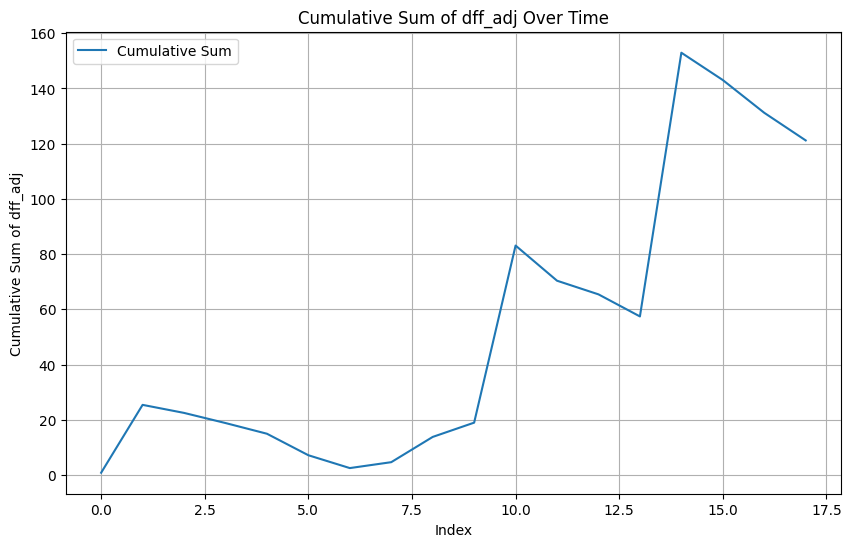

In [156]:
import matplotlib.pyplot as plt

# 計算累積和
earn_data_reset = earn_data_reset['dff_adj'].cumsum()

# 畫圖
plt.figure(figsize=(10, 6))
plt.plot(earn_data_reset, label='Cumulative Sum')
plt.xlabel('Index')
plt.ylabel('Cumulative Sum of dff_adj')
plt.title('Cumulative Sum of dff_adj Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [130]:
collected_data3[collected_data3['持有天數_停損'] != -100][['Date','stock_id', 'stock_name', '收盤價_停損dff','dff_adj', '收盤價_dff','收盤價_隔天收盤_dff','持有天數_af','持有天數_停損' ]].sort_values(by='Date')
#collected_data3[collected_data3['stock_id'] == '8040']
#collected_data3[collected_data3['持有天數_停損'] != -100]

,Date,stock_id,stock_name,收盤價_停損dff,dff_adj,收盤價_dff,收盤價_隔天收盤_dff,持有天數_af,持有天數_停損
5,2023-04-14,2739,寒舍,-2.91,-2.91,-8.26,-8.41,13,10
3,2023-04-24,6752,叡揚,-3.87,-3.87,5.06,6.85,23,1
4,2023-05-03,2230,泰茂,-7.79,-7.79,-8.01,-7.00,5,1
6,2023-07-11,3362,先進光,-4.65,-4.65,3.88,4.26,30,1
11,2024-01-16,6243,迅杰,-12.73,-12.73,-15.14,-13.99,13,9
14,2024-02-22,8467,波力-KY,-7.99,-7.99,-6.19,-10.82,5,1
16,2024-05-07,4994,傳奇,-9.89,-9.89,-11.66,-7.42,3,1
17,2024-07-05,6213,聯茂,-10.0,-10.00,-14.44,-14.44,5,3


In [135]:
print(collected_data3[collected_data3['持有天數_停損'] != -100]['持有天數_af'].sum())
print(collected_data3[collected_data3['持有天數_停損'] != -100]['持有天數_停損'].sum())

97
27


In [69]:
tomorrow_close_buy 

35.35

In [33]:
collected_data3

,RS20_rank_p,slope,rs_value,stock_id,stock_name,Date,收盤價,隔天買進價,隔天最低價,收盤價_RS小於,...,隔天收盤_RS小於,隔天開盤_RS小於,收盤價_dff,收盤價_停損dff,開盤價_dff,收盤價_隔天收盤_dff,收盤價_隔天開盤_dff,持有天數,持有天數_af,持有天數_停損
0,25,2.75,77,8089,康全電訊,2024-01-31,65.0,65.0,64.1,72.0,...,71.8,69.8,10.77,-1,18.46,10.46,7.38,37,40,-1


In [19]:
collected_data3

,RS20_rank_p,slope,rs_value,stock_id,stock_name,Date,收盤價,隔天收盤價,隔天最低價,收盤價_RS小於,開盤價_RS小於,隔天收盤_RS小於,隔天開盤_RS小於,收盤價_dff,開盤價_dff,收盤價_隔天收盤_dff,收盤價_隔天開盤_dff,持有天數,持有天數_af
0,25,2.75,77,8089,康全電訊,2024-01-31,65.00,65.00,64.10,72.00,77.0,71.80,69.80,10.77,18.46,10.46,7.38,37,40
1,25,2.75,77,8467,波力-KY,2024-02-22,194.00,194.00,176.50,174.00,172.5,182.00,175.00,-10.31,-11.08,-6.19,-9.79,7,8
2,25,2.75,77,3289,宜特,2024-04-29,145.50,145.50,141.00,132.50,133.5,133.00,133.00,-8.93,-8.25,-8.59,-8.59,8,9
3,25,2.75,77,5310,天剛,2024-08-09,54.50,54.50,50.10,49.30,51.7,50.40,49.60,-9.54,-5.14,-7.52,-8.99,12,13
4,25,2.75,77,8040,九暘,2024-06-18,102.00,102.00,91.80,89.90,90.0,88.40,90.50,-11.86,-11.76,-13.33,-11.27,7,8
5,25,2.75,77,4994,傳奇,2024-05-07,141.50,141.50,127.50,131.00,125.0,131.00,129.50,-7.42,-11.66,-7.42,-8.48,3,6
6,25,2.75,77,5529,鉅陞,2024-04-22,30.05,30.05,27.65,30.55,31.0,31.05,30.75,1.66,3.16,3.33,2.33,17,18
7,25,2.75,77,6213,聯茂,2024-07-05,135.00,135.00,121.50,115.50,122.5,115.50,116.00,-14.44,-9.26,-14.44,-14.07,4,5
8,25,2.75,77,3060,銘異,2024-05-16,33.45,33.45,31.80,33.65,33.5,32.15,33.80,0.60,0.15,-3.89,1.05,19,20
9,25,2.75,77,5522,遠雄,2024-06-03,94.80,94.80,93.50,87.80,88.2,87.20,88.00,-7.38,-6.96,-8.02,-7.17,11,14


In [46]:
collected_data

,rs_value,stock_id,stock_name,Date,收盤價,隔天收盤價,隔天最低價,收盤價_RS小於,開盤價_RS小於,隔天收盤_RS小於,隔天開盤_RS小於,收盤價_dff,開盤價_dff,收盤價_隔天收盤_dff,收盤價_隔天開盤_dff,持有天數,持有天數_af
0,77,3454,晶睿,2022-11-02,161.50,161.50,159.50,171.00,173.50,175.00,171.00,5.88,7.43,8.36,5.88,21,22
1,77,3332,幸康,2023-02-20,47.00,47.00,46.20,47.40,47.95,46.60,47.30,0.85,2.02,-0.85,0.64,15,16
2,77,6752,叡揚,2023-04-24,168.00,168.00,156.50,176.50,168.00,179.50,176.00,5.06,0.00,6.85,4.76,22,23
3,77,2230,泰茂,2023-05-03,88.60,88.60,81.20,81.50,81.50,82.40,83.00,-8.01,-8.01,-7.00,-6.32,2,5
4,77,2739,寒舍,2023-04-14,65.40,65.40,63.00,60.00,58.50,59.90,60.90,-8.26,-10.55,-8.41,-6.88,12,13
5,77,2722,夏都,2023-05-22,57.50,57.50,55.90,89.40,92.10,88.30,86.50,55.48,60.17,53.57,50.43,45,46
6,77,3362,先進光,2023-07-11,129.00,129.00,123.00,134.00,140.00,134.50,135.00,3.88,8.53,4.26,4.65,29,30
7,77,1905,華紙,2023-06-01,28.15,28.15,27.75,27.00,27.40,26.65,27.15,-4.09,-2.66,-5.33,-3.55,12,13
8,77,6148,驊宏資,2023-06-16,48.75,48.75,48.20,47.95,45.70,43.20,43.20,-1.64,-6.26,-11.38,-11.38,21,24
9,77,5906,台南-KY,2023-06-19,75.90,75.90,75.10,73.70,76.10,72.70,74.80,-2.90,0.26,-4.22,-1.45,17,18


In [47]:
profolio_df1

,slope_angle5_p,rs_value,mean_close,mean_open,mean_close_af,mean_open_af,hold_day_mean,hold_day_mean_af,pen_close,pen_open,pen_close_af,pen_open_af,diff_pen_close,diff_pen_open
0,2.75,77,7.464444,6.826667,6.558333,7.095,20.444444,21.888889,0.365109,0.333913,0.299619,0.324137,-0.906111,0.268333


In [38]:
profolio_df1.sort_values(by='pen_close_af', ascending= False)  

,slope_angle5_p,rs_value,mean_close,mean_open,mean_close_af,mean_open_af,hold_day_mean,hold_day_mean_af,pen_close,pen_open,pen_close_af,pen_open_af,diff_pen_close,diff_pen_open
9,2.75,79,5.043333,3.960000,6.765000,5.760000,20.00,21.500000,0.252167,0.198000,0.314651,0.267907,1.721667,1.800000
4,2.50,79,4.811500,4.717500,5.809500,5.554000,20.65,22.150000,0.233002,0.228450,0.262280,0.250745,0.998000,0.836500
14,3.00,79,1.056000,-0.084000,5.252000,2.118000,19.00,20.400000,0.055579,-0.004421,0.257451,0.103824,4.196000,2.202000
6,2.75,76,5.398333,3.380833,5.523333,5.575833,20.50,22.166667,0.263333,0.164919,0.249173,0.251541,0.125000,2.195000
7,2.75,77,5.398333,3.380833,5.523333,5.575833,20.50,22.166667,0.263333,0.164919,0.249173,0.251541,0.125000,2.195000
8,2.75,78,5.398333,3.380833,5.523333,5.575833,20.50,22.166667,0.263333,0.164919,0.249173,0.251541,0.125000,2.195000
5,2.75,75,5.228333,3.721667,5.065000,5.340000,21.00,22.500000,0.248968,0.177222,0.225111,0.237333,-0.163333,1.618333
3,2.50,78,5.024500,4.370000,5.064500,5.443500,20.95,22.550000,0.239833,0.208592,0.224590,0.241397,0.040000,1.073500
2,2.50,77,4.916000,4.252500,5.073500,5.380500,21.00,22.600000,0.234095,0.202500,0.224491,0.238075,0.157500,1.128000
1,2.50,76,4.582500,4.154000,4.770000,5.085000,21.10,22.750000,0.217180,0.196872,0.209670,0.223516,0.187500,0.931000


In [ ]:


df_within_10_percent[['證券代號','證券名稱','收盤價', '5MA', '8MA','10MA','20MA','60MA','240MA']]

collected_data2[collected_data2['證券代號'].isin(df_within_10_percent[df_within_10_percent['收盤價'] < df_within_10_percent['20MA']]['證券代號'])]

# df_within_10_percent[['證券代號','證券名稱','收盤價', '5MA', '8MA','10MA','20MA','60MA','240MA']]
# df_within_10_percent[df_within_10_percent['證券代號'] == '2516']

# #5328  3013 2516
# df_within_10_percent[df_within_10_percent['收盤價'] < df_within_10_percent['20MA']]


In [97]:
import warnings
# 計算出場  使用60RS看看
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

RS_down = list(range(72, 74, 1))

profolio_df1 = pd.DataFrame(columns=['rs_value', 'mean_close', 'mean_open', 'mean_close_af','mean_open_af','hold_day_mean','hold_day_mean_af'])

for rs_value in RS_down:

    collected_data = pd.DataFrame(columns=['rs_value','stock_id', 'stock_name', 'Date', '收盤價', '隔天收盤價', '隔天最低價',
                                           '收盤價_RS小於','開盤價_RS小於','隔天收盤_RS小於','隔天開盤_RS小於', 
                                           '收盤價_dff','開盤價_dff','收盤價_隔天收盤_dff','收盤價_隔天開盤_dff','持有天數','持有天數_af'])
    
    for i in range(len(collected_data2)):
        temp_df = collected_data2.iloc[i].copy()

        filter_day = pd.to_datetime(temp_df['Date'])
        # filter_day30 = filter_day + pd.Timedelta(days=hold_day)
        filter_stock_id = temp_df['證券代號']


        # 篩到之後 隔天一開盤要買 (回測起來 隔天收盤買效果好像更好ㄟ)

        tomorrow_close_buy = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['收盤價'].iloc[0]
        tomorrow_low_buy = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['最低價'].iloc[0]

        # 隔日不追高 如果開盤開太高就算了 開盤直接掛昨天收盤價買買看
        if tomorrow_low_buy > temp_df['收盤價']:
            continue
        else :
            tomorrow_close_buy = temp_df['收盤價']


        # tomorrow_open = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['開盤價'].iloc[0]

        # 找到跌落RS後 不可能那天開盤價可以賣 要重測一次
        RS75_df_t = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['20RS_rank'] < rs_value)].copy()
        # 這天是技術面需要離場的日子
        getout_day = RS75_df_t['Date'].iloc[0]
        # 真正能夠離場的日子
        RS75_df = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > getout_day.strftime('%Y-%m-%d'))].copy()

        

        if RS75_df.empty:
            continue

        getout_day_df = RS75_df.iloc[0] # 符合條件當天
        af_getout_day_df = RS75_df.iloc[1] # 符合條件隔天

        diff_day = (getout_day_df['Date'] - temp_df['Date']).days

        diff_close = round(100 * (getout_day_df['收盤價'] / tomorrow_close_buy - 1), 2) #撈出來當天買
        diff_open = round(100 * (getout_day_df['開盤價'] / tomorrow_close_buy - 1), 2)  #撈出來隔天買

        diff_day_af = (af_getout_day_df['Date'] - temp_df['Date']).days

        diff_close_af = round(100 * (af_getout_day_df['收盤價'] / tomorrow_close_buy - 1), 2)
        diff_open_af = round(100 * (af_getout_day_df['開盤價'] / tomorrow_close_buy - 1), 2)


        result_df = pd.DataFrame({
            'rs_value': [rs_value],
            'stock_id': [filter_stock_id],
            'stock_name': [temp_df['證券名稱']],
            'Date': [temp_df['Date']],
            '收盤價': [temp_df['收盤價']],
            '隔天收盤價': [tomorrow_close_buy],
            '隔天最低價': [tomorrow_low_buy],
            '收盤價_RS小於': [getout_day_df['收盤價']],
            '開盤價_RS小於': [getout_day_df['開盤價']],
            '隔天收盤_RS小於': [af_getout_day_df['收盤價']],
            '隔天開盤_RS小於': [af_getout_day_df['開盤價']],
            '收盤價_dff': [diff_close],
            '開盤價_dff': [diff_open],
            '收盤價_隔天收盤_dff': [diff_close_af],
            '收盤價_隔天開盤_dff': [diff_open_af],
            '持有天數': [diff_day],
            '持有天數_af': [diff_day_af]
        })

        # 删除全为NA的列，避免可能出现的警告
        result_df.dropna(axis=1, how='all', inplace=True)

        if not result_df.empty:
            collected_data = pd.concat([collected_data, result_df], ignore_index=True)

    # 仅当collected_data不为空时，计算mean并合并到profolio_df中
    if not collected_data.empty:
        mean_close = collected_data['收盤價_dff'].mean()
        mean_open = collected_data['開盤價_dff'].mean()
        mean_close_af = collected_data['收盤價_隔天收盤_dff'].mean()
        mean_open_af = collected_data['收盤價_隔天開盤_dff'].mean()
        hold_day_mean = collected_data['持有天數'].mean()
        hold_day_mean_af = collected_data['持有天數_af'].mean()
        profolio_data = pd.DataFrame({
            'rs_value': [rs_value],
            'mean_close': [mean_close],
            'mean_open': [mean_open],
            'mean_close_af': [mean_close_af],
            'mean_open_af': [mean_open_af],
            'hold_day_mean' : [hold_day_mean],
            'hold_day_mean_af' : [hold_day_mean_af],
        })
        profolio_df1 = pd.concat([profolio_df1, profolio_data], ignore_index=True)



        
        
profolio_df1['pen_close'] = profolio_df1['mean_close']/ profolio_df1['hold_day_mean']  
profolio_df1['pen_open'] = profolio_df1['mean_open']/ profolio_df1['hold_day_mean']

profolio_df1['pen_close_af'] = profolio_df1['mean_close_af']/ profolio_df1['hold_day_mean_af']
profolio_df1['pen_open_af'] = profolio_df1['mean_open_af']/ profolio_df1['hold_day_mean_af']

profolio_df1['diff_pen_close'] = profolio_df1['mean_close_af'] - profolio_df1['mean_close']
profolio_df1['diff_pen_open'] = profolio_df1['mean_open_af'] - profolio_df1['mean_open']



print('======profolio_df1======diff_pen=================')
print(profolio_df1['diff_pen_close'].mean())
print(profolio_df1['diff_pen_open'].mean())
profolio_df1


======profolio_df1======diff_pen=================
0.8745238095238093
1.0398809523809522


,rs_value,mean_close,mean_open,mean_close_af,mean_open_af,hold_day_mean,hold_day_mean_af,pen_close,pen_open,pen_close_af,pen_open_af,diff_pen_close,diff_pen_open
0,72,2.907381,2.553810,3.773095,3.562143,19.619048,21.142857,0.148192,0.130170,0.178457,0.168480,0.865714,1.008333
1,73,2.957143,2.551667,3.840476,3.623095,19.452381,21.023810,0.152020,0.131175,0.182673,0.172333,0.883333,1.071429


In [99]:

collected_data[collected_data['stock_id'].isin(collected_data2[collected_data2['證券代號'].isin(filter_stock_uni[filter_stock_uni['slope5_count'] >6]['證券代號'])]['證券代號'])]


,rs_value,stock_id,stock_name,Date,收盤價,隔天收盤價,隔天最低價,收盤價_RS小於,開盤價_RS小於,隔天收盤_RS小於,隔天開盤_RS小於,收盤價_dff,開盤價_dff,收盤價_隔天收盤_dff,收盤價_隔天開盤_dff,持有天數,持有天數_af
14,73,6148,驊宏資,2023-06-16,48.75,48.75,48.2,47.95,45.7,43.2,43.2,-1.64,-6.26,-11.38,-11.38,21,24
35,73,3228,金麗科,2024-01-03,301.00,301.00,293.0,494.00,452.0,475.0,499.0,64.12,50.17,57.81,65.78,50,51


In [67]:
collected_data['買點差'] = collected_data['收盤價'] - collected_data['隔天最低價']
collected_data['跳空'] = ((collected_data['隔天最低價']/ collected_data['收盤價'])-1)*100
collected_data.sort_values(by='收盤價_隔天開盤_dff', ascending=True).head(20)
collected_data.sort_values(by='收盤價_隔天開盤_dff', ascending=False).head(20)
# collected_data['買點差'] = collected_data['收盤價'] - collected_data['隔天最低價']
# collected_data[collected_data['買點差'] > 0]['收盤價_隔天開盤_dff'].mean()
# collected_data[collected_data['買點差'] < 0]['收盤價_隔天開盤_dff'].mean()

# collected_data['收盤價_隔天開盤_dff'].mean()

,rs_value,stock_id,stock_name,Date,收盤價,隔天收盤價,隔天最低價,收盤價_RS小於,開盤價_RS小於,隔天收盤_RS小於,隔天開盤_RS小於,收盤價_dff,開盤價_dff,收盤價_隔天收盤_dff,收盤價_隔天開盤_dff,持有天數,持有天數_af,買點差,跳空
30,79,3228,金麗科,2024-01-03,301.00,301.00,293.00,494.00,452.00,475.00,499.00,64.12,50.17,57.81,65.78,50,51,8.00,-2.657807
34,79,1519,華城,2024-01-15,376.50,376.50,364.00,514.00,504.00,525.00,530.00,36.52,33.86,39.44,40.77,56,57,12.50,-3.320053
35,79,4909,新復興,2024-01-09,36.80,36.80,34.00,47.30,46.90,52.00,49.70,28.53,27.45,41.30,35.05,37,38,2.80,-7.608696
36,79,6462,神盾,2024-01-05,142.00,142.00,136.50,162.50,162.50,176.00,172.00,14.44,14.44,23.94,21.13,11,12,5.50,-3.873239
33,79,1514,亞力,2024-02-26,94.40,94.40,89.40,109.50,110.00,110.00,110.50,16.00,16.53,16.53,17.06,31,32,5.00,-5.296610
24,79,2516,新建,2023-11-15,10.05,10.05,9.65,11.75,11.60,11.55,11.70,16.92,15.42,14.93,16.42,21,22,0.40,-3.980100
31,79,3362,先進光,2024-01-31,205.00,205.00,203.00,237.00,252.50,240.00,237.00,15.61,23.17,17.07,15.61,40,41,2.00,-0.975610
1,79,8936,國統,2023-06-30,32.95,32.95,32.20,36.80,36.65,36.30,36.80,11.68,11.23,10.17,11.68,31,32,0.75,-2.276176
25,79,2465,麗臺,2023-11-30,63.60,63.60,61.20,68.50,66.00,66.90,69.00,7.70,3.77,5.19,8.49,22,25,2.40,-3.773585
16,79,6117,迎廣,2023-10-02,42.10,42.10,42.00,43.00,40.95,47.30,44.50,2.14,-2.73,12.35,5.70,22,23,0.10,-0.237530


In [14]:
df_within_10_percent[df_within_10_percent['證券代號'] == '8027']

# ㄏ字形中間盤整區間 高低差不要大於20% max_min_diff < 0.2
temp_df_his = stock_df_raw[(stock_df_raw['證券代號']=='8027') & (stock_df_raw['Date'] < '2024-12-31') & (stock_df_raw['收盤價'] != 0) ].copy()
# 一年內高低點
temp_df_his.loc[:, 'relax_day_min'] = temp_df_his['收盤價'].rolling(relax_day).min()
temp_df_his.loc[:, 'relax_day_max'] = temp_df_his['收盤價'].rolling(relax_day).max()

relax_day_min = temp_df_his.tail(1)['relax_day_min'].iloc[0]
relax_day_max = temp_df_his.tail(1)['relax_day_max'].iloc[0]

if (relax_day_min == 0) |  (relax_day_max == 0) :
        print('relax_day = 0 stock_name:' + temp_df['證券名稱'].iloc[0] + "today_str" + filter_day + "stock_id" + filter_stock_id)
else:
        max_min_diff = abs(relax_day_min - relax_day_max) / relax_day_min 


# 計算20日線斜率  ㄏ   
temp_his_tail20 = temp_df_his.tail(relax_day).copy()
temp_his_tail20['20MA_Slope'] = temp_his_tail20['20MA'].diff() / temp_his_tail20['20MA'].shift(1)
# 将斜率转换为角度
temp_his_tail20['Slope_Angle20'] = np.degrees(np.arctan(temp_his_tail20['20MA_Slope']))
# 第一天不會有斜率
temp_his_tail20 = temp_his_tail20.dropna()


# 計算5日線斜率  ㄏ   
temp_his_tail5 = temp_df_his.tail(up_day).copy()
temp_his_tail5['5MA_Slope'] = temp_his_tail5['5MA'].diff() / temp_his_tail5['5MA'].shift(1)
temp_his_tail5['Slope_Angle5'] = np.degrees(np.arctan(temp_his_tail5['5MA_Slope']))
# 第一天不會有斜率
temp_his_tail5 = temp_his_tail5.dropna()


slope20_count = len(temp_his_tail20[temp_his_tail20['Slope_Angle20'] < 0])
slope5_count = len(temp_his_tail5[temp_his_tail5['Slope_Angle5'] > 2.5])

print(slope20_count)
print(slope5_count)

4
0


In [17]:
temp_his_tail5['Slope_Angle5']

1536408   -1.226905
1538257   -0.916269
1540107   -1.421075
1541958   -1.959355
1543809   -1.092703
1545660   -0.689638
1547511   -0.268488
1549362   -1.122034
1551213   -1.507436
1553064   -2.620507
1554915   -1.859061
1556766   -2.960094
1558617   -1.226288
1560468    0.316621
1562320    1.023264
1564173    0.206238
1566025    0.937507
1567877    0.833978
1569729    0.647664
1571582    0.935961
1573434    0.714948
1575286    0.526623
1577135    0.201620
1578985    1.252555
1580835    1.422272
1582685    1.376549
1584533    1.101918
1586380    1.308093
1588230    0.422839
Name: Slope_Angle5, dtype: float64

In [ ]:

# 
filter_stock_list2 = pd.DataFrame(columns=['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價'])

# 盤整時間
relax_day = 20
stock_id_filter = []

for i in range(len(filter_stock_uni)):
        temp_df = filter_stock_uni.iloc[i].copy()

        # 均線糾結那天 
        filter_day = pd.to_datetime(temp_df['Date'])
        # STOCK ID
        filter_stock_id = temp_df['證券代號']

        # ㄏ字形中間盤整區間 高低差不要大於20% max_min_diff < 0.2
        temp_df_his = stock_df_raw[(stock_df_raw['證券代號']==filter_stock_id) & (stock_df_raw['Date'] < filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['收盤價'] != 0) ].copy()
        # 一年內高低點
        temp_df_his.loc[:, 'relax_day_min'] = temp_df_his['收盤價'].rolling(relax_day).min()
        temp_df_his.loc[:, 'relax_day_max'] = temp_df_his['收盤價'].rolling(relax_day).max()

        relax_day_min = temp_df_his.tail(1)['relax_day_min'].iloc[0]
        relax_day_max = temp_df_his.tail(1)['relax_day_max'].iloc[0]

        if (relax_day_min == 0) |  (relax_day_max == 0) :
                print('relax_day = 0 stock_name:' + temp_df['證券名稱'].iloc[0] + "today_str" + filter_day + "stock_id" + filter_stock_id)
        else:
                max_min_diff = abs(relax_day_min - relax_day_max) / relax_day_min 


        # 計算斜率        
        temp_his_tail = temp_df_his.tail(relax_day).copy()

        temp_his_tail['20MA_Slope'] =  temp_his_tail['20MA'].diff() / 1
        temp_his_tail['5MA_Slope'] =  temp_his_tail['5MA'].diff() / 1

        slope20_count = len(temp_his_tail[temp_his_tail['20MA_Slope'] < 0])
        slope5_count = len(temp_his_tail[temp_his_tail['5MA_Slope'] < -2])

        if( (slope20_count == 0) & (slope5_count == 0) & (max_min_diff < 0.2) & (temp_df['收盤價'] > temp_df['8MA']) &  (temp_df['收盤價'] * 1.2 > relax_day_max) ):
                stock_id_filter.append(filter_stock_id) 


filter_stock = df_within_10_percent[df_within_10_percent['證券代號'].isin(stock_id_filter)]

filter_stock = filter_stock[['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價']]

filter_stock
